In [1]:
import pandas as pd
import gzip
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12


SRR9900120 (Day 0): intra 51.21%, inter 48.79%
SRR9900121 (Day 3): intra 34.67%, inter 65.33%
SRR9900122 (Day 7): intra 26.72%, inter 73.28%


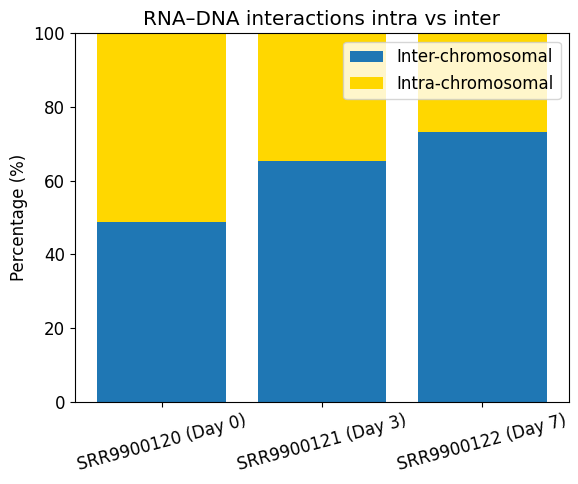

In [3]:
# This script calculates the percentage of intra- and inter-chromosomal RNA–DNA interactions 
# from iMARGI .pairs.gz files and visualizes the results as a stacked bar chart.

import gzip
import matplotlib.pyplot as plt

# Sample file paths
pairs_files = {
    "SRR9900120 (Day 0)": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "SRR9900121 (Day 3)": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "SRR9900122 (Day 7)": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

intra_ratios = []
inter_ratios = []
labels = []

for sample_name, file_path in pairs_files.items():
    inter_count = 0
    intra_count = 0
    total = 0

    with gzip.open(file_path, "rt") as f:
        for line in f:
            if line.startswith("#"):  # Skip header
                continue
            cols = line.strip().split("\t")
            chrom1, chrom2 = cols[1], cols[3]
            total += 1
            if chrom1 == chrom2:
                intra_count += 1
            else:
                inter_count += 1

    intra_ratio = intra_count / total * 100
    inter_ratio = inter_count / total * 100

    labels.append(sample_name)
    intra_ratios.append(intra_ratio)
    inter_ratios.append(inter_ratio)

    print(f"{sample_name}: intra {intra_ratio:.2f}%, inter {inter_ratio:.2f}%")

# Plot stacked bar chart
x = range(len(labels))
plt.figure(figsize=(6, 5))
# Blue bars (inter) at the bottom
plt.bar(x, inter_ratios, color="#1f77b4", label="Inter-chromosomal")

# Yellow bars (intra) on top, bottom is the height of inter
plt.bar(x, intra_ratios, bottom=inter_ratios, color="#FFD700", label="Intra-chromosomal")

plt.xticks(x, labels, rotation=15)
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.legend()
plt.title("RNA–DNA interactions intra vs inter")

plt.tight_layout()
plt.show()

Total number of super-enhancer regions: 912

===> Processing Day0
Day0: Number of enhancer regions overlapping with iMARGI = 820
Percentage = 89.91%

===> Processing Day3
Day3: Number of enhancer regions overlapping with iMARGI = 836
Percentage = 91.67%

===> Processing Day7
Day7: Number of enhancer regions overlapping with iMARGI = 815
Percentage = 89.36%


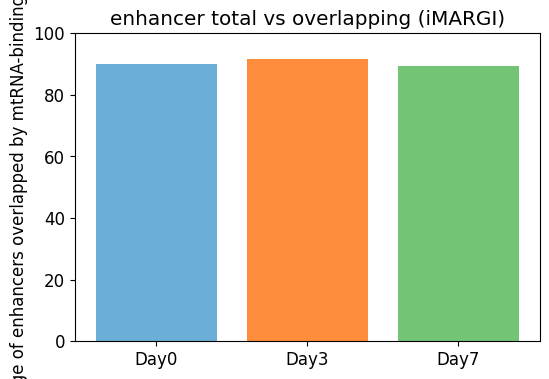

In [4]:
# This script analyzes how many enhancer regions overlap with DNA-end sites 
# from mtRNA-binding RNA–DNA interactions detected by iMARGI and visualizes the 
# percentage for each sample as a bar chart.

import gzip
import pybedtools
import matplotlib.pyplot as plt

# Background super-enhancer BED file
candidate_bed = pybedtools.BedTool("/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/ref/HUVEC_superenhancer_hg19.bed")

# Sample .pairs.gz files
pairs_files = {
    "Day0": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

total_regions = len(candidate_bed)
print(f"Total number of super-enhancer regions: {total_regions}")

results = {}

for name, pf in pairs_files.items():
    print(f"\n===> Processing {name}")
    dna_sites = []
    
    # Extract DNA-end coordinates where RNA-end = mtRNA (chrM)
    with gzip.open(pf, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            cols = line.strip().split("\t")
            rna_chr = cols[1]
            dna_chr, dna_pos = cols[3], int(cols[4])
            if rna_chr in ["chrM", "chrMT", "MT"]:
                dna_sites.append([dna_chr, dna_pos, dna_pos+1])
    
    # Merge DNA-end coordinates ±250bp
    if len(dna_sites) == 0:
        print(f"{name}: No mtRNA reads")
        results[name] = (0, 0)
        continue
        
    dna_bed = pybedtools.BedTool(dna_sites).sort().merge(d=500)

    # Calculate overlaps
    overlap_count = candidate_bed.intersect(dna_bed, u=True).count()
    results[name] = (overlap_count, overlap_count / total_regions * 100)

    print(f"{name}: Number of enhancer regions overlapping with iMARGI = {overlap_count}")
    print(f"Percentage = {overlap_count / total_regions:.2%}")

# Plot bar chart
labels = list(results.keys())
overlap_counts = [results[k][0] for k in labels]
percentages = [results[k][1] for k in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, percentages, color=["#6baed6", "#fd8d3c", "#74c476"])
plt.ylabel("Percentage of enhancers overlapped by mtRNA-binding sites (%)")
plt.title("enhancer total vs overlapping (iMARGI)")
plt.ylim(0, 100)
plt.show()


The proportion is very high (89–92%)

Almost all super-enhancers overlap with the mtRNA-binding regions detected by iMARGI

This indicates that mtRNA binding on enhancers is very widespread and does not occur only in a few regions

The proportions are almost the same across the three time points

The difference between Day 3 and Day 7 is very small (91.67% vs 89.36%)